# Lec 17 Lab: The Lasso
## CMSE 381 - Fall 2022
## Oct 19, 2022



In this module we are going to test out the lasso method, discussed in class.

In [1]:
# Everyone's favorite standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time


# ML imports we've used previously
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



# Loading in the data

Ok, here we go, let's play with a baseball data set again. Note this cleanup is all the same as the last lab. 

In [2]:
hitters_df = pd.read_csv('Hitters.csv')

# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df = hitters_df.dropna().drop('Player', axis=1)

# Replace any categorical variables with dummy variables
hitters_df = pd.get_dummies(hitters_df, drop_first = True)

hitters_df.head()

Dimensions of original data: (322, 21)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


In [3]:
y = hitters_df.Salary

# Drop the column with the independent variable (Salary)
X = hitters_df.drop(['Salary'], axis = 1).astype('float64')

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    float64
 17  Division_W   263 non-null    float64
 18  NewLeague_N  263 non-null    float64
dtypes: float

We had an issue last class with normalization. While there are internal methods from `scikitlearn` to do this, they make the code more complicated, so for now, let's just do it manually. 

In [4]:
# Manually normalizing 

X_Normalized = X/X.std() # Note that X.std() is a list of columns, so this does it columnwise
X_Normalized

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,2.138388,1.795001,0.799351,0.939709,1.468161,1.795741,2.920551,1.508364,1.288183,0.839441,0.969207,1.280276,1.420154,2.257670,0.296387,1.513644,1.999449,1.996555,2.001424
2,3.251708,2.880866,2.055473,2.584200,2.781779,3.499392,0.625832,0.710230,0.705030,0.766446,0.676331,0.822593,0.996001,3.143592,0.565203,2.119101,0.000000,1.996555,0.000000
3,3.367113,3.124631,2.283859,2.545046,3.013594,1.703652,2.294719,2.461315,2.429807,2.737307,2.500011,2.591477,1.340625,0.714453,0.075820,0.454093,1.999449,0.000000,2.001424
4,2.179119,1.927964,1.141930,1.527027,1.622705,1.381339,0.417222,0.173184,0.155816,0.145990,0.144928,0.142253,0.124974,2.875672,0.275709,0.605458,1.999449,0.000000,2.001424
5,4.032389,3.745125,0.456772,2.897437,1.970427,1.611562,2.294719,1.927767,1.747918,0.231150,1.512688,1.039065,0.734693,1.007378,2.901836,3.784109,0.000000,1.996555,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,3.373901,2.814384,0.799351,2.545046,1.854520,1.703652,1.043054,1.182113,1.243444,0.389306,1.144329,0.961754,0.522617,1.160986,0.062034,0.454093,1.999449,0.000000,2.001424
318,3.339959,3.013829,0.570965,2.975746,1.931791,4.328196,2.503329,2.410147,2.331072,0.474467,2.708345,1.394697,3.313693,1.118118,2.626127,3.027288,0.000000,0.000000,0.000000
319,3.224554,2.792224,0.342579,2.388428,1.661340,2.394321,1.251665,0.743467,0.668004,0.085161,0.655196,0.287598,0.552913,0.132174,0.778878,1.059551,0.000000,1.996555,0.000000
320,3.889830,3.191113,1.027737,3.328137,2.318149,3.591482,1.668886,1.398593,1.322124,1.180083,1.419088,1.298831,1.257310,4.693954,0.902947,1.816373,0.000000,0.000000,0.000000


Finally lets get a simple train/test split to work with (Validation style), and a list of $\alpha$s to test for our Lasso.

In [5]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X_Normalized, y, test_size=0.3, random_state=1)

# List of alphas
alphas = 10**np.linspace(4,-2,100)*0.5
# alphas = np.append(alphas,0)
alphas

array([5.00000000e+03, 4.34874501e+03, 3.78231664e+03, 3.28966612e+03,
       2.86118383e+03, 2.48851178e+03, 2.16438064e+03, 1.88246790e+03,
       1.63727458e+03, 1.42401793e+03, 1.23853818e+03, 1.07721735e+03,
       9.36908711e+02, 8.14875417e+02, 7.08737081e+02, 6.16423370e+02,
       5.36133611e+02, 4.66301673e+02, 4.05565415e+02, 3.52740116e+02,
       3.06795364e+02, 2.66834962e+02, 2.32079442e+02, 2.01850863e+02,
       1.75559587e+02, 1.52692775e+02, 1.32804389e+02, 1.15506485e+02,
       1.00461650e+02, 8.73764200e+01, 7.59955541e+01, 6.60970574e+01,
       5.74878498e+01, 5.00000000e+01, 4.34874501e+01, 3.78231664e+01,
       3.28966612e+01, 2.86118383e+01, 2.48851178e+01, 2.16438064e+01,
       1.88246790e+01, 1.63727458e+01, 1.42401793e+01, 1.23853818e+01,
       1.07721735e+01, 9.36908711e+00, 8.14875417e+00, 7.08737081e+00,
       6.16423370e+00, 5.36133611e+00, 4.66301673e+00, 4.05565415e+00,
       3.52740116e+00, 3.06795364e+00, 2.66834962e+00, 2.32079442e+00,
      

# Lasso 

Thanks to the wonders of `scikit-learn`, now that we know how to do all this with ridge regression, translation to lasso is super easy. 

- [Lasso Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
- [LassoCV Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)
- [User guide](https://scikit-learn.org/stable/modules/linear_model.html#lasso)



In [6]:
from sklearn.linear_model import Lasso, LassoCV

In [7]:
# Here's a quick lasso code for a fixed $\alpha$
lasso = Lasso(max_iter = 10000)
# max_iter increases how long the lasso model tries to find a good solution
# In our case, if I leave it at the default 1000 I was getting errors, so I
# upped the value. 
lasso.set_params(alpha=1)
lasso.fit(X_train, y_train)

mean_squared_error(y_test,lasso.predict(X_test))


120804.22994952144

&#9989; **<font color=red>Do this:</font>** Make a few graphs similar to what we did in the previous lab, but using Lasso instead of Ridge. 
- A graph of the coeffiencts as alpha changes 
- A graph of the test mean squared error as alpha changes

*Note: we did similar things in the last class, you should be able to borrow and modify code from there*

Text(0, 0.5, 'weights')

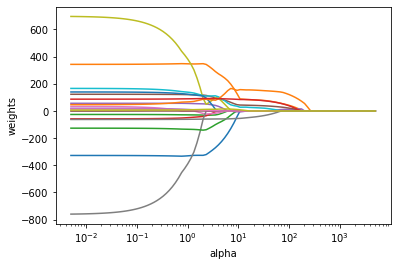

In [26]:
# Your code for a graph of the coefficients goes here 
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

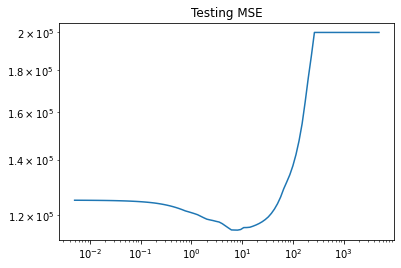

In [10]:
# Your code for a graph of the MSEs goes here
lasso = Lasso(max_iter = 10000)
MSE = []

for a in alphas:
    # ==== Your code goes in here ==== #
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)

    test_yhat = lasso.predict(X_test)
    mse_test = mean_squared_error(test_yhat,y_test)
    
    
    MSE.append(mse_test)
    
plt.plot(alphas,MSE)
plt.title('Testing MSE')
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

&#9989; **<font color=red>Do this:</font>** Now try what we did with `LassoCV`.  What choice of $\alpha$ does it recommend? 

*I would actually recommend either not passing in any $\alpha$ list or passing explicitly `alphas = None`. `RidgeCV` can't do this, but `LassoCV` will automatically try to find good choices of $\alpha$ for you.*

In [19]:
# Your code here
lassocv = LassoCV(alphas = None, max_iter = 10000)
lassocv.fit(X_train, y_train)
lassocv.alpha_

1.141875094883512

Now let's take a look at some of the coefficients. 

In [20]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lassocv.coef_, index=X.columns)

AtBat         -328.631103
Hits           346.658007
HmRun          -28.728111
Runs           -47.646482
RBI             55.032657
Walks          119.650493
Years           -0.000000
CAtBat        -353.355205
CHits          349.947241
CHmRun         136.063156
CRuns          120.885819
CRBI            67.995938
CWalks        -135.035461
PutOuts         89.920742
Assists         10.074126
Errors           0.124336
League_N         8.822397
Division_W     -60.906200
NewLeague_N      9.183987
dtype: float64

&#9989; **<font color=red>Q:</font>** We've been repeating over and over that lasso gives us coefficients that are actually 0.  At least in my code, I'm not seeing any that are 0. What happened? Can I change something to get more 0 entries? 

*Your answer here*

In [24]:
# You might also want some code in here to try to figure it out
lassocv = LassoCV(alphas = None, max_iter = 10000)
lassocv.fit(X_train, y_train)
pd.Series(lassocv.coef_, index=X.columns)

AtBat         -328.631103
Hits           346.658007
HmRun          -28.728111
Runs           -47.646482
RBI             55.032657
Walks          119.650493
Years           -0.000000
CAtBat        -353.355205
CHits          349.947241
CHmRun         136.063156
CRuns          120.885819
CRBI            67.995938
CWalks        -135.035461
PutOuts         89.920742
Assists         10.074126
Errors           0.124336
League_N         8.822397
Division_W     -60.906200
NewLeague_N      9.183987
dtype: float64



-----
### Congratulations, we're done!
Written by Dr. Liz Munch, Michigan State University

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.